In [2]:
################## IMPORT LIBRARIES ##################
import soundfile as sf
from IPython.display import Audio
import numpy as np
import random 
import pandas as pd
import os
from os.path import join as pjoin
import tqdm
from acoustics.bands import third
import scipy.signal as sig
from IPython.display import Audio
# from masp import shoebox_room_sim as srs
from scipy.io import wavfile
#import mat73
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 3)
import torch
import sklearn


In [67]:
################## IMPORT MY MODULES ##################

import sys
sys.path.append('../src')
import joa_helpers as hlp
import cond_waveunet_dataset as dset
import cond_waveunet_model as cwaveunet
from cond_waveunet_traintest import infer
import cond_waveunet_eval as eval
import importlib
importlib.reload(hlp)
importlib.reload(dset)
importlib.reload(cwaveunet)
importlib.reload(eval)

2024-01-08 15:59:59.916673: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-08 16:00:00.535667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<module 'cond_waveunet_eval' from '/home/ubuntu/joanna/reverb-match-cond-u-net/notebooks/../src/cond_waveunet_eval.py'>

### <font color='fuchsia'>Inspect datapoints:</font>

In [128]:
################## LOAD TRAINING PARAMETERS  ##################

# load arguments used for training

# args=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-18-11-2023/19-11-2023--23-13_one-to-many_lr-0.001_bs-8/trainargs.pt")
# args=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-18-11-2023/19-11-2023--00-20_many-to-many_lr-0.0001_bs-8/trainargs.pt")

args=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-11-12-2023/11-12-2023--16-25_many-to-many_lr-0.0001_bs-8trainargs.pt")
# args=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-11-12-2023/12-12-2023--16-26_one-to-many_lr-0.0001_bs-8trainargs.pt")


In [129]:
################## LOAD DATASET AND CHECK 1 DATAPOINT SAMPLE  ##################

# instantiate a test data set 
args.split="test"
dataset=dset.DatasetReverbTransfer(args)
# get one data sample 
sContent_in, sStyle_in, sTarget_out = dataset[0]

# playback for the data sample
audios=[sContent_in, sStyle_in, sTarget_out]
names=["sContent_in", "sStyle_in", "sTarget_out"]

for i,audio in enumerate(audios):
    print(names[i])
    audio=audio.squeeze(0).cpu()
    display(Audio(audio,rate=48e3))


sContent_in


sStyle_in


sTarget_out


###  <font color='fuchsia'>Inspect inference with trained models:</font>

In [130]:
################## LOAD MODELS AND TRAINING WEIGHTS  ##################


# load reverb encoder
model_ReverbEncoder=cwaveunet.ReverbEncoder(args)
model_ReverbEncoder.to("cuda")
model_ReverbEncoder.eval()
# check waveunet 
model_waveunet=cwaveunet.waveunet(args)
model_waveunet.to("cuda")
model_waveunet.eval()
# load training results
# train_results=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-18-11-2023/20-11-2023--10-23_one-to-many_lr-0.0001_bs-8/checkpoint27.pt",map_location=args.device)
# train_results=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-18-11-2023/19-11-2023--06-13_many-to-many_lr-0.0001_bs-24/checkpoint27.pt",map_location=args.device)

# train_results=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-11-12-2023/12-12-2023--16-26_one-to-many_lr-0.0001_bs-8checkpoint90.pt",map_location=args.device)
train_results=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-11-12-2023/11-12-2023--16-25_many-to-many_lr-0.0001_bs-8checkpoint120.pt",map_location=args.device)



model_waveunet.load_state_dict(train_results["model_waveunet_state_dict"])
model_ReverbEncoder.load_state_dict(train_results["model_reverbenc_state_dict"])


<All keys matched successfully>

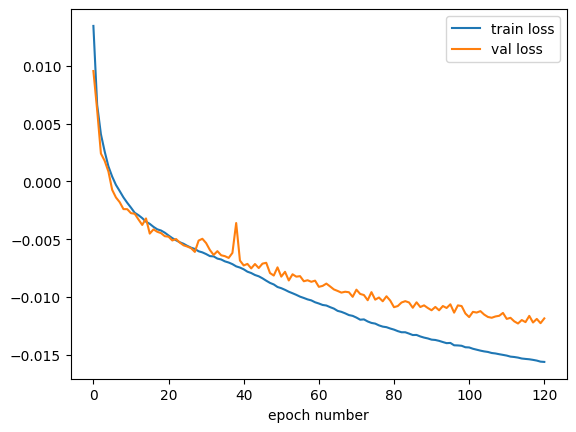

In [131]:
################## PLOT TRAINING LOSS EVOLUTION  ##################

# load and plot the loss evolution 
loss = list(zip(*train_results['loss']))
plt.figure()
plt.plot(loss[0],label="train loss")
plt.plot(loss[1],label="val loss")
plt.xlabel("epoch number")
plt.legend()
plt.show()

In [140]:
################## INFERENCE FOR ONE DATA SAMPLE  ##################

def infer(model_reverbenc, model_waveunet, data, device):
    with torch.no_grad():
        # Function to infer target audio
        # ------------------------------
        # get datapoint
        sContent_in = data[0].to(device)
        sStyle_in=data[1].to(device)
        sTarget_gt=data[2].to(device)
        # forward pass - get prediction of the ir
        embedding_gt=model_reverbenc(sStyle_in.unsqueeze(0))
        sTarget_prediction=model_waveunet(sContent_in.unsqueeze(0),embedding_gt)
        return sContent_in, sStyle_in, sTarget_gt, sTarget_prediction

sContent_in, sStyle_in, sTarget_gt, sTarget_prediction=infer(model_ReverbEncoder, model_waveunet, dataset[8], args.device)

sContent_in:


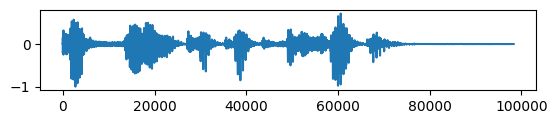

sStyle_in:


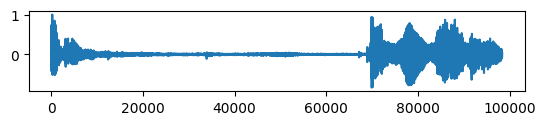

sTarget_gt:


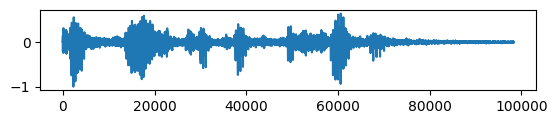

sTarget_prediction:


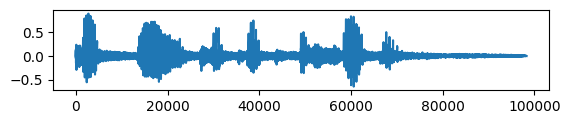

In [141]:
################## PLOT AND PLAY BACK CONTENT, STYLE, TARGET AND PREDICTION ##################

audios=[sContent_in, sStyle_in, sTarget_gt, sTarget_prediction]
names=["sContent_in", "sStyle_in", "sTarget_gt", "sTarget_prediction"]

plt.figure()
for i,audio in enumerate(audios):
    print(names[i]+":")
    plt.subplot(4,1,i+1)
    audio=audio.squeeze(0).cpu()
    if i==3:
        audio=audio.squeeze(0)
    plt.plot(audio)
    plt.show()
    display(Audio(audio,rate=48e3))


###  <font color='fuchsia'>Evaluation of the latent space</font>

In [9]:
################## GENERATE EMBEDDING ARRAY AND PARAMETER ARRAYS FROM MULTIPLE DATA POINTS ##################

emb_arr=np.zeros([len(dataset),512])
rt30_meas_arr=np.zeros([len(dataset),1])
edt_meas_arr=np.zeros([len(dataset),1])
c50_meas_arr=np.zeros([len(dataset),1])
rt60_set_arr=np.zeros([len(dataset),1])
rt60_true_arr=np.zeros([len(dataset),1])
for j,data in enumerate(dataset):
    # get style audio
    sStyle_in=data[1]
    # get style info
    df_Style=dataset.get_info(j,style=True)
    # get style embedding of size 512
    with torch.no_grad():
        embedding=model_ReverbEncoder(sStyle_in.unsqueeze(0).to(args.device))
        emb_arr[j,:]=embedding.cpu().numpy()
    rt30_meas_arr[j]=df_Style["rt30_meas"]
    rt60_set_arr[j]=df_Style["rt60_set"]
    rt60_true_arr[j]=df_Style["rt60_true"]
    edt_meas_arr[j]=df_Style["edt_meas"]
    c50_meas_arr[j]=df_Style["c50_meas"]
    if j==1000:
        break


In [10]:
################## PERFORM DIMENSIONALITY REDUCTION ON THE EMBEDDING SPACE ##################

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

indices_subset=range(1000)
# reduce dimensionality of the embeddings
# using pca:
embeddings_pca=PCA(n_components=2).fit_transform(emb_arr[indices_subset,:])
# using first pca and then tsne:
embeddings_pca_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(PCA(n_components=50).fit_transform(emb_arr[indices_subset,:]))
# using tsne:
embeddings_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(emb_arr[indices_subset,:])

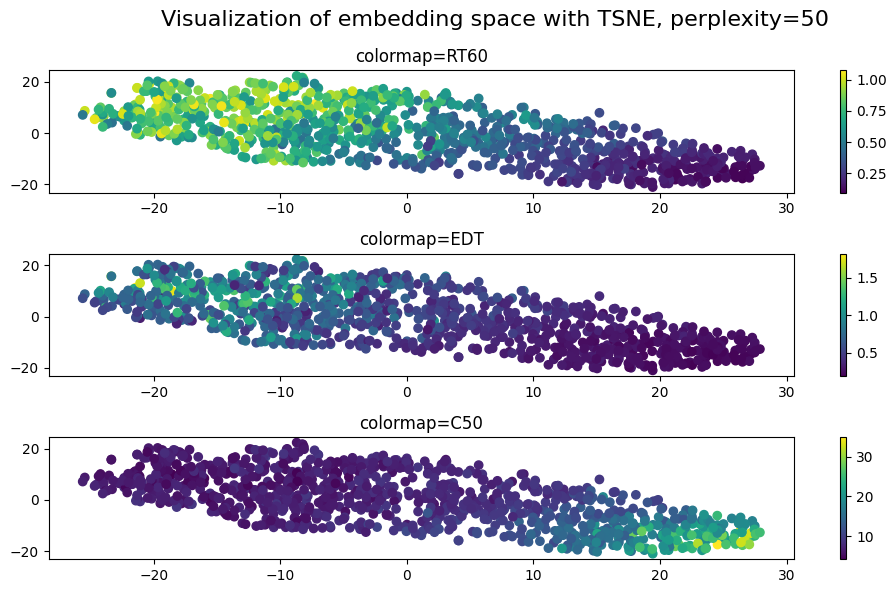

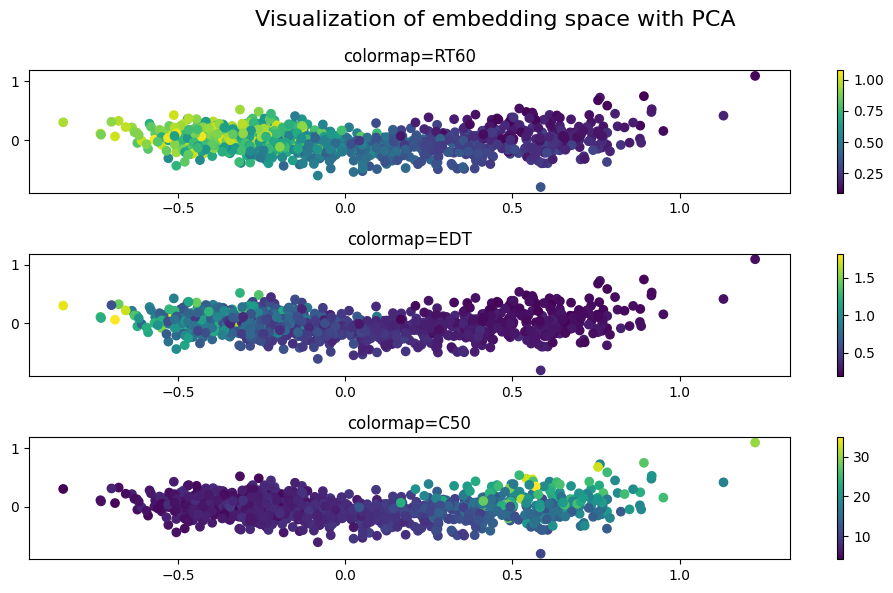

In [11]:
################## PLOT TSNE 2-DIM VISUALISATION OF THE EMBEDDING SPACE ##################

# plt.figure(figsize=(10,6))
# plt.suptitle('Visualization of embeddings with TSNE, perplexity=50', fontsize=16)
# plt.subplot(2,3,1)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt30_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=rt30 meas')
# plt.subplot(2,3,2)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt60_true_arr[indices_subset]);plt.colorbar();plt.title('colormap=rt60 meas')
# plt.subplot(2,3,3)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt60_set_arr[indices_subset]);plt.colorbar();plt.title('colormap=rt60 set')
# plt.subplot(2,3,4)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=edt_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=edt')
# plt.subplot(2,3,5)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=c50_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=c50')
# cmap = plt.get_cmap('cool')
# plt.set_cmap(cmap)


plt.figure(figsize=(10,6))
plt.suptitle('Visualization of embedding space with TSNE, perplexity=50', fontsize=16)
plt.subplot(3,1,1)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt60_true_arr[indices_subset]);plt.colorbar();plt.title('colormap=RT60')
plt.subplot(3,1,2)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=edt_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=EDT')
plt.subplot(3,1,3)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=c50_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=C50')

plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
plt.suptitle('Visualization of embedding space with PCA', fontsize=16)
plt.subplot(3,1,1)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=rt60_true_arr[indices_subset]);plt.colorbar();plt.title('colormap=RT60')
plt.subplot(3,1,2)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=edt_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=EDT')
plt.subplot(3,1,3)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=c50_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=C50')

plt.tight_layout()
plt.show()

###  <font color='fuchsia'>Compare training results: 18-11-2023 (conditions with different hyperparameter combinations) </font>

In [13]:
################## LOADING AND PREPARING RESULTS OF EVALUATION ##################

import speechmetrics 

resultsdir="/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-18-11-2023/"

# load data frame containing evaluation metrics computed for each batch
metricsvals =pd.read_csv(pjoin(resultsdir,"evaluation_metrics.csv"))

# compute a mean of each measure across all testing batches 
metricsvals_groups=metricsvals.groupby("label").mean().reset_index()

# create xticks for the plot
tickss = [i for i in range(0, len(metricsvals_groups))]
width=0.35


In [14]:
metricsvals_groups

,label,nb_pesq_input,pesq_input,stoi_input,stftloss_input,nb_pesq_predict,pesq_predict,stoi_predict,stftloss_predict,styleloss_input,styleloss_predict
0,many-to-many_lr-0.0001_bs-24,2.792605,1.998135,0.866868,1.049151,2.854526,2.125407,0.879407,0.970231,0.998927,0.999879
1,many-to-many_lr-0.0001_bs-8,2.789234,1.993260,0.866119,1.049633,2.838643,2.094338,0.873270,0.992471,0.998654,0.999880
2,many-to-many_lr-0.001_bs-24,2.789005,1.991656,0.866514,1.050049,2.835408,2.085583,0.877903,1.000845,0.998617,0.999801
3,many-to-many_lr-0.001_bs-8,2.786195,1.991779,0.866549,1.050822,2.839366,2.094184,0.877632,0.999263,0.998437,0.999724
4,many-to-many_lr-1e-05_bs-24,2.788024,1.990150,0.866709,1.050695,2.801345,2.021275,0.860672,1.107349,0.999989,0.999988
5,many-to-many_lr-1e-05_bs-8,2.787288,1.993435,0.866230,1.050749,2.839811,2.103157,0.876933,1.009374,0.999883,0.999972
6,one-to-many_lr-0.0001_bs-24,2.470913,1.750308,0.900779,1.103646,2.783990,2.094574,0.904140,0.913602,0.997124,0.999694
7,one-to-many_lr-0.0001_bs-8,2.472859,1.747066,0.900035,1.102275,2.793292,2.116918,0.906913,0.892252,0.997353,0.999779
8,one-to-many_lr-0.001_bs-24,2.472379,1.748528,0.900662,1.101645,2.572778,1.831943,0.855065,1.005086,0.996392,0.999710
9,one-to-many_lr-0.001_bs-8,2.467431,1.742308,0.901678,1.103012,2.709755,2.009166,0.901923,0.907714,0.993417,0.999804


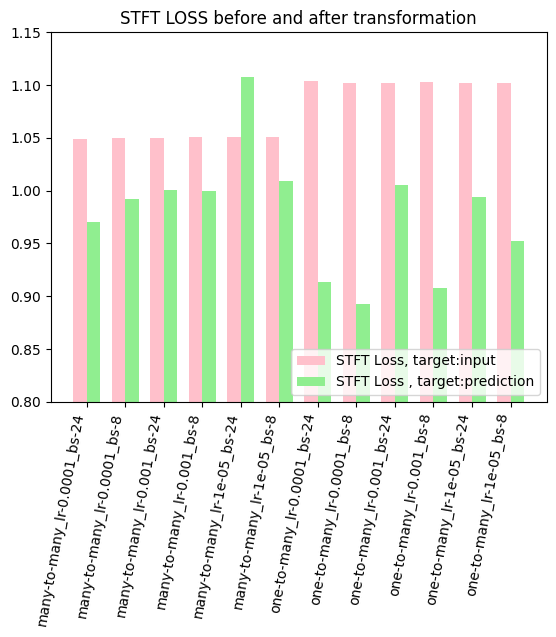

In [47]:
################## PLOT EVALUATION RESULTS: STFT LOSS ##################

plt.figure()
plt.bar(np.array(tickss)- width/2,metricsvals_groups['stftloss_input'],width,label="STFT Loss, target:input", color="pink")
plt.bar(np.array(tickss)+ width/2,metricsvals_groups['stftloss_predict'],width,label="STFT Loss , target:prediction", color="lightgreen")
plt.xticks(tickss,metricsvals_groups["label"],rotation=80,horizontalalignment="right", verticalalignment="top")
plt.ylim(0.8,1.15)
plt.legend(loc='lower right')
plt.title("STFT LOSS before and after transformation")
plt.show()

STFT Loss: 

- STFT loss is a measure of how close two audio signals are to each other, minimizing this loss is an objective of our network
- For almost all training parameters, after training the network the signal transformed by our approach is closer to the target then the input signal
- The average stft loss for many-to-many is lower than for one-to-many. Its because in many-to-many the input signal already has some amount of reverb, which makes it initially closer to the target. 
- For many-to-many the best parameters are lr=1e-4 and bs=24, and the worst is lr=1e-5 and bs=24 (the transformation makes the signal further from the target!)
- For one-to-many the best parameters are lr=1e-4 and bs=8, and the worst is lr=0.001 and bs=24

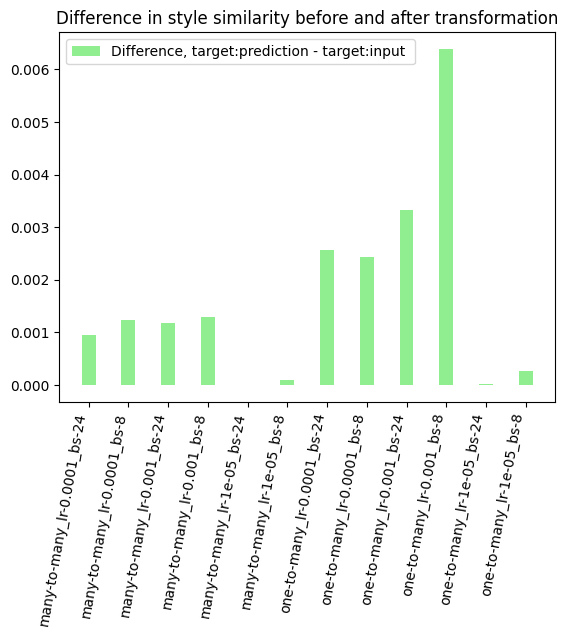

In [61]:
################## PLOT EVALUATION RESULTS: STYLE SIMILARITY ##################

plt.figure()
# plt.bar(np.array(tickss)- width/2,metricsvals_groups['styleloss_input'],width,label="Style Similarity, target:input", color="pink")
# plt.bar(np.array(tickss)+ width/2,metricsvals_groups['styleloss_predict'],width,label="Style Similarity, target:prediction", color="lightgreen")
plt.bar(tickss,metricsvals_groups['styleloss_predict']-metricsvals_groups['styleloss_input'],width,label="Difference, target:prediction - target:input ", color="lightgreen")
plt.xticks(tickss,metricsvals_groups["label"],rotation=80,horizontalalignment="right", verticalalignment="top")
plt.title("Difference in style similarity before and after transformation")
plt.legend(loc='upper left')
plt.show()

STYLE SIMILARITY: 

- Style similarity is the cosine similarity loss between the style embeddings of two audio signals
- The style similarity depends on the model training, that is why the values differ both for input and for prediction. 
- The objective of the training is to obtain a transformation which changes the style of signal, so that it is closer to the target at the output than at the input. This objective is fulfilled for most of the training parameters. If there is no difference in style before and after the transformation, than it probably means the encoder has not been trained properly. 
- For many-to-many the best parameters (leading to a biggest difference) are lr=0.001 and bs=8, and the worst is lr=1e-5 and bs=24 
- For one-to-many the best parameters are lr=0.001 and bs=8, and the worst is lr=1e-5 and bs=24
- This measure is not so informative as it depends both on the room encoding network and style transfer network 

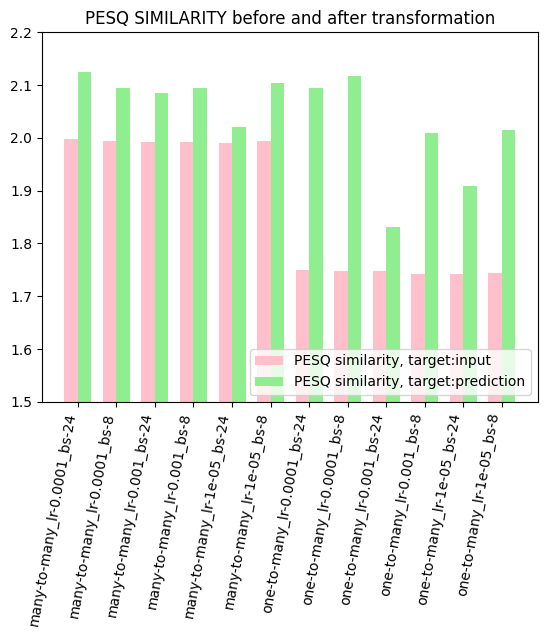

In [62]:
################## PLOT EVALUATION RESULTS: PESQ SIMILARITY ##################

plt.figure()
plt.bar(np.array(tickss)- width/2,metricsvals_groups['pesq_input'],width,label="PESQ similarity, target:input", color="pink")
plt.bar(np.array(tickss)+ width/2,metricsvals_groups['pesq_predict'],width,label="PESQ similarity, target:prediction", color="lightgreen")
plt.xticks(tickss,metricsvals_groups["label"],rotation=80,horizontalalignment="right", verticalalignment="top")
plt.ylim(1.5,2.2)
plt.title("PESQ SIMILARITY before and after transformation")
plt.legend(loc='lower right')
plt.show()

PESQ SIMILARITY: 

- PESQ similarity is a similarity measure based on the PESQ score, which is typically used to compare clean and enhanced signals. Typically, the closer the enhanced signal to the clean signal, the higher the pesq value, which means the better performance of an enhancing algorithm. Here, we use this measure to compare PESQ(target signal, input signal) with PESQ(target signal, predicted signal). If our approach is working then PESQ(target signal, predicted signal) is higher than PESQ(target signal, input signal).
- For many-to-many the best parameters are lr=1e-4 and bs=24, and the worst is lr=1e-5 and bs=24 (same as STFT loss)
- For one-to-many the best parameters are lr=1e-4 and bs=8, and the worst is lr=0.001 and bs=24 (same as STFT Loss)
- In the korean study the PESQ goes from 2.643 to 3.105 in the best model  

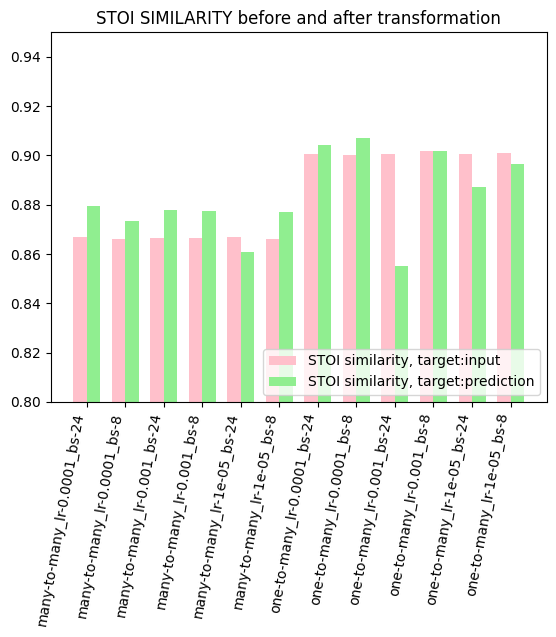

In [63]:
################## PLOT EVALUATION RESULTS: STOI SIMILARITY ##################

plt.figure()
plt.bar(np.array(tickss)- width/2,metricsvals_groups['stoi_input'],width,label="STOI similarity, target:input", color="pink")
plt.bar(np.array(tickss)+ width/2,metricsvals_groups['stoi_predict'],width,label="STOI similarity, target:prediction", color="lightgreen")
plt.xticks(tickss,metricsvals_groups["label"],rotation=80,horizontalalignment="right", verticalalignment="top")
plt.title("STOI SIMILARITY before and after transformation")
plt.ylim(0.8,0.95)
plt.legend(loc='lower right')
plt.show()

STOI SIMILARITY: 

- STOI similarity is a similarity measure based on the STOI score, which is typically used to compare clean and enhanced signals. Typically, the closer the enhanced signal to the clean signal, the higher the STOI value, which means the better performance of an enhancing algorithm. Here, we use this measure to compare STOI(target signal, input signal) with STOI(target signal, predicted signal). If our approach is working then STOI(target signal, predicted signal) is higher than STOI(target signal, input signal).
- For many-to-many the best parameters are lr=1e-4 and bs=24, and the worst is lr=1e-5 and bs=24 (same as STFT loss)
- For one-to-many the best parameters are lr=1e-4 and bs=8, and the worst is lr=0.001 and bs=24 (same as STFT Loss)
- In the korean study the STOI goes from 78% to 80.92% in the best model

GENERAL OBSERVATIONS: 

- For many-to-many the condition with the lowest cumulative loss (lr=0.0001 and bs=8) is not the same condition as the one which corresponds to the lowest stft loss, and objective metrics (lr=0.0001 and bs=24), which means that trying to fulfill the second objective (style loss) is preventing the network from getting to low stft loss (?)
- For one-to-many the condition with the lowest cumulative loss is the same as the condition that leads to the lowest stft loss

###  <font color='fuchsia'>Compare training results: 11-12-2023 (best* conditions trained longer) - compare checkpoints
*actually for many-to-many is not the best condition, it is only the one that looks best based on the loss function (see 1 cell above)

 </font>

In [17]:
################## LOADING AND PREPARING RESULTS OF EVALUATION ##################

resultsdir="/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-11-12-2023/"

# load data frame containing evaluation metrics computed for each batch
metricsvals =pd.read_csv(pjoin(resultsdir,"evaluation_metrics_evol.csv"))

# compute a mean of each measure across all testing batches 
metricsvals_groups=metricsvals.groupby("label").mean().reset_index()
desired_order = [0, 2, 3, 4, 1, 5 ,6 ,7 ,8]
metricsvals_groups = metricsvals_groups.reindex(desired_order)


# create xticks for the plot
tickss = [i for i in range(0, len(metricsvals_groups))]
width=0.35


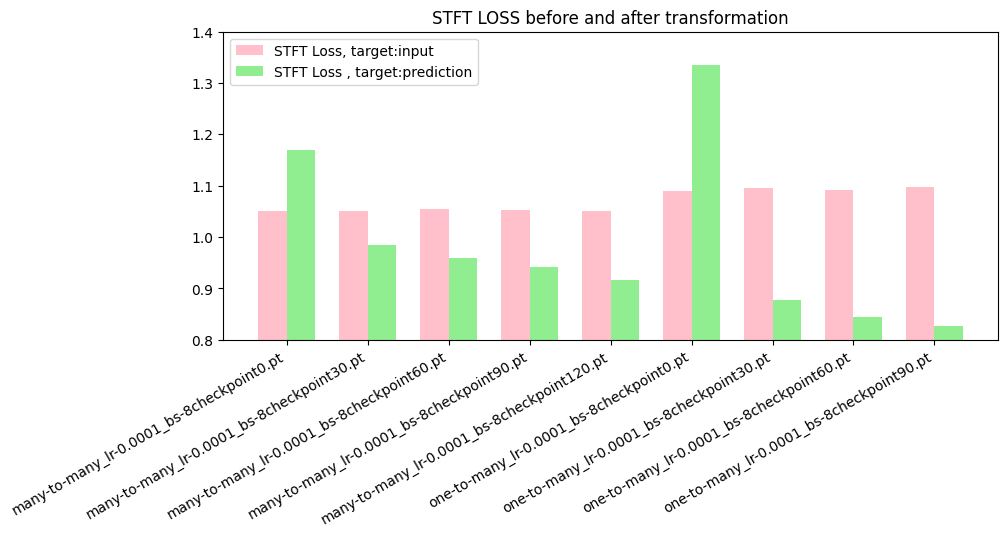

In [18]:
################## PLOT EVALUATION RESULTS: STFT LOSS ##################

plt.figure(figsize=(10,4))
plt.bar(np.array(tickss)- width/2,metricsvals_groups['stftloss_input'],width,label="STFT Loss, target:input", color="pink")
plt.bar(np.array(tickss)+ width/2,metricsvals_groups['stftloss_predict'],width,label="STFT Loss , target:prediction", color="lightgreen")
plt.xticks(tickss,metricsvals_groups["label"],rotation=30,horizontalalignment="right", verticalalignment="top")
plt.ylim(0.8,1.4)
plt.legend(loc='upper left')
plt.title("STFT LOSS before and after transformation")
plt.show()

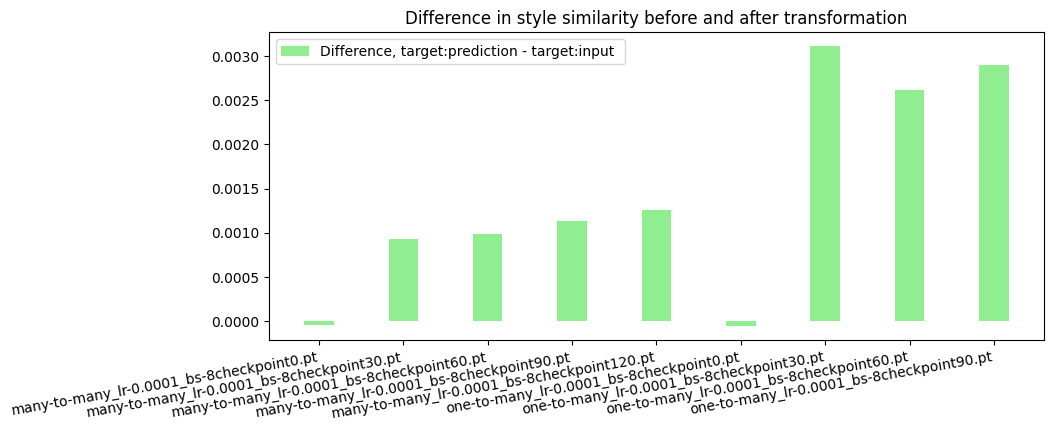

In [20]:
################## PLOT EVALUATION RESULTS: STYLE SIMILARITY ##################

plt.figure(figsize=(10,4))
# plt.bar(np.array(tickss)- width/2,metricsvals_groups['styleloss_input'],width,label="Style Similarity, target:input", color="pink")
# plt.bar(np.array(tickss)+ width/2,metricsvals_groups['styleloss_predict'],width,label="Style Similarity, target:prediction", color="lightgreen")
plt.bar(tickss,metricsvals_groups['styleloss_predict']-metricsvals_groups['styleloss_input'],width,label="Difference, target:prediction - target:input ", color="lightgreen")
plt.xticks(tickss,metricsvals_groups["label"],rotation=10,horizontalalignment="right", verticalalignment="top")
plt.title("Difference in style similarity before and after transformation")
plt.legend(loc='upper left')
plt.show()

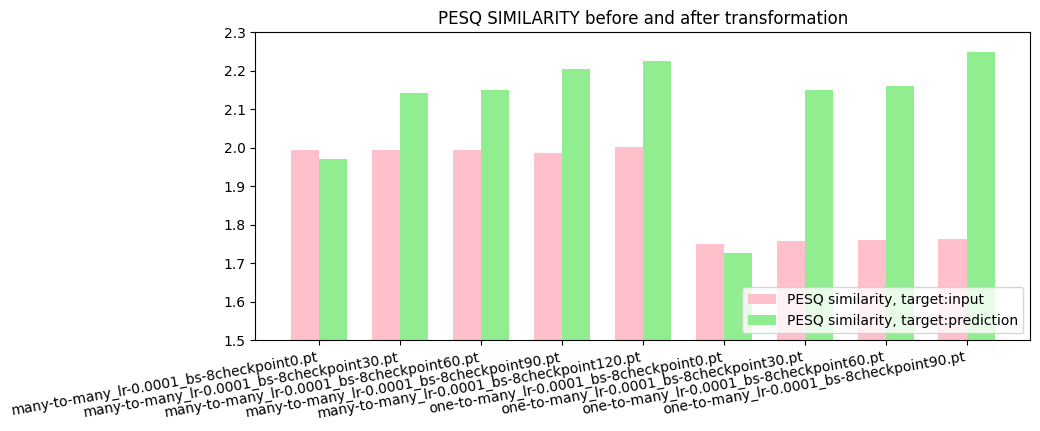

In [21]:
################## PLOT EVALUATION RESULTS: PESQ SIMILARITY ##################

plt.figure(figsize=(10,4))
plt.bar(np.array(tickss)- width/2,metricsvals_groups['pesq_input'],width,label="PESQ similarity, target:input", color="pink")
plt.bar(np.array(tickss)+ width/2,metricsvals_groups['pesq_predict'],width,label="PESQ similarity, target:prediction", color="lightgreen")
plt.xticks(tickss,metricsvals_groups["label"],rotation=10,horizontalalignment="right", verticalalignment="top")
plt.ylim(1.5,2.3)
plt.title("PESQ SIMILARITY before and after transformation")
plt.legend(loc='lower right')
plt.show()

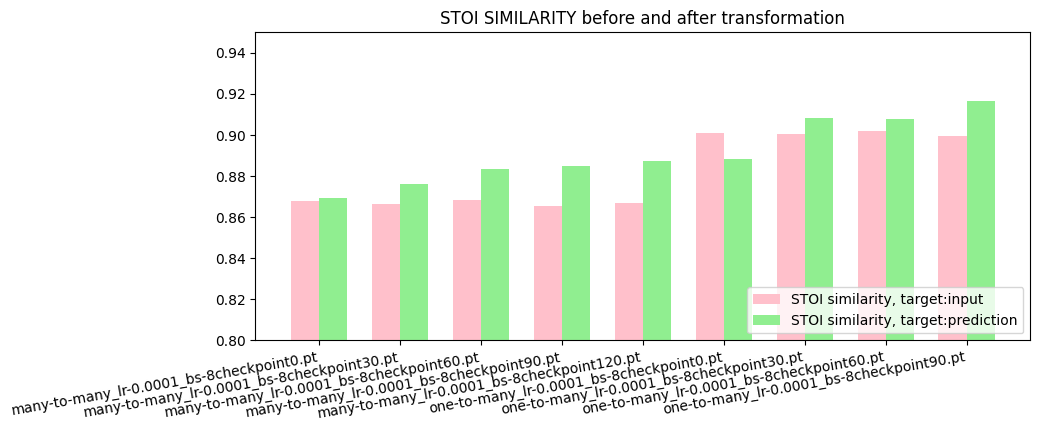

In [22]:
################## PLOT EVALUATION RESULTS: STOI SIMILARITY ##################

plt.figure(figsize=(10,4))
plt.bar(np.array(tickss)- width/2,metricsvals_groups['stoi_input'],width,label="STOI similarity, target:input", color="pink")
plt.bar(np.array(tickss)+ width/2,metricsvals_groups['stoi_predict'],width,label="STOI similarity, target:prediction", color="lightgreen")
plt.xticks(tickss,metricsvals_groups["label"],rotation=10,horizontalalignment="right", verticalalignment="top")
plt.title("STOI SIMILARITY before and after transformation")
plt.ylim(0.8,0.95)
plt.legend(loc='lower right')
plt.show()

- Improvement for STOI is bigger for many-to-many than for one-to-many. 

    rev1 target:rev2 input -> rev1 target:rev1 prediction 
    is bigger than:
    rev1 target:anechoic input -> rev1 target:rev2 prediction

    Interpretation: Replacing false reverberation has a bigger impact on speech intelligibility than adding correct reverberation to the anechoic signal. 


- Improvement for PESQ is smaller for many-to-many than for one-to-many. 

    rev1 target:rev2 input -> rev1 target:rev1 prediction 
    is smaller than:
    rev1 target:anechoic input -> rev1 target:rev2 prediction 

    Interpretation: Adding correct reverberation to the anechoic signal has a bigger effect on speech quality than replacing the wrong reverberation. 

